## ***Jupyter Notebook to accompany the paper:***
    
# ***Embracing uncertainty to resolve polar wander: a case study of Cenozoic North America***

### ***by L. C. Gallo<sup>1<sup>*** *(len.gallo@gmail.com)****, M. Domeier<sup>1</sup>, F. Sapienza<sup>2</sup>, N. Swanson-Hysell<sup>3</sup>, B. Vaes<sup>4</sup>, Y. Zhang<sup>3</sup>, M. Arnaould<sup>5</sup>, A. Eyster<sup>6</sup>,  D. Gürer<sup>7</sup>, A. Kiraly<sup>1</sup>, B. Robert<sup>8</sup>, T. Rolf<sup>1</sup>, G. Shephard<sup>1</sup> and A. van der Boon<sup>1</sup>***

*(1) Centre for Earth Evolution and Dynamics, University of Oslo, Norway.*
*(2) Department of Statistics, University of California, Berkeley, United States.*
*(3) Department of Earth and Planetary Science, University of California, Berkeley, United States.*
*(4) Department of Earth Sciences, Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands.*
*(5) Laboratoire de Géologie de Lyon - Terre, Planètes, Environnement, University Lyon 1 Claude Bernard, Lyon, France*
*(6) Department of Geoscience, University of Wisconsin-Madison, Madison, WI USA*
*(7) Research School of Earth Sciences, Australian National University, Canberra, Australian Capital Territory, Australia.*
*(8) Institut de Physique du Globe de Paris, Université de Paris, Paris, France.*

## Import scientific Python libraries

Import scipy python libraries as well as functions written for the project within vgptools.

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
sns.set_style("white")

from pmagpy import ipmag, pmag

from vgptools.utils import (spherical2cartesian,GCD_cartesian) 
from vgptools.utils_APWPs import (running_mean_APWP, get_pseudo_vgps, MC_error_prop_ensemble_results)
from vgptools.utils_visualization import  plot_pole, plot_pole_A95
from vgptools.utils_classes import PC, quantiles
np.random.seed(1)

## Compiles a DataFrame for both, the VGPs and the recomputed poles by study

In [2]:
current_path = os.getcwd()
data_path = os.path.join(current_path, '..') + '/data'

In [3]:
df_filtered_directions = pd.read_csv(data_path +'/vgps_filtered.csv')
df_pole_compilation  = pd.read_csv(data_path +'/poles_by_study.csv')

# list to store the models
models = []

## 1. Moving average classic approach on poles

Set the classical parameters

In [4]:
min_age = 0
max_age = 65
window_length = 20
time_step = 10

Run the Moving average on paleopoles 

(Note: There may be multiple poles for each file, as multiple studies have been conducted in the same area. This is basically the content of each datasheet)

In [5]:
RM_1_classic = running_mean_APWP(df_pole_compilation, "Plon", "Plat", "mean_age", window_length, time_step, max_age, min_age)
RM_1_classic['method'] = "RM_classic"
models.append(RM_1_classic)
RM_1_classic.head(10)

,age,N,n_studies,k,A95,csd,plon,plat,foliation,lineation,...,elong_dir,effective_age,effective_age_std,effective_age_median,distance2age,GCD,APW_rate,APW_rate_eff_age,angle,method
0,0.0,17.0,15.0,155.075584,2.873466,6.504491,0.000000,-90.000000,0.673561,4.819217,...,52.950148,3.0,2.660540,2.0,7.0,NaN,NaN,NaN,NaN,RM_classic
1,10.0,18.0,15.0,154.995795,2.785329,6.506165,-54.986373,-87.258735,0.699943,4.806285,...,48.438290,3.0,3.083519,2.0,-9.0,0.375266,0.037527,NaN,163.155600,RM_classic
2,20.0,7.0,6.0,576.253052,2.516820,3.374259,-11.644529,-81.643535,2.379876,5.904994,...,28.613948,23.0,6.110628,23.0,-0.0,6.633272,0.663327,0.331664,34.800316,RM_classic
3,30.0,9.0,6.0,349.329544,2.758480,4.333785,-24.177273,-82.732378,3.247998,5.317064,...,27.575510,28.0,5.752823,28.0,-8.0,2.015489,0.201549,0.403098,174.815216,RM_classic
4,40.0,12.0,7.0,98.584757,4.393069,8.157933,-40.490636,-83.196526,1.225104,4.243296,...,-94.358672,42.0,6.478276,43.0,8.0,2.043825,0.204382,0.145987,31.005744,RM_classic
5,50.0,12.0,9.0,83.449008,4.779163,8.866953,-27.811855,-81.677918,0.806618,4.186000,...,-92.200769,48.0,3.989616,48.0,-11.0,2.247606,0.224761,0.374601,176.322765,RM_classic
6,60.0,4.0,4.0,222.541387,6.172545,5.429747,-13.837826,-78.640250,1.695166,5.163581,...,-34.503896,52.0,2.254028,51.0,-4.0,3.843211,0.384321,0.960803,NaN,RM_classic


### 2. Running means ensemble from $pseudo$-VGPs approach (Vaes et al. 2022)

In [6]:
min_age = 0
max_age = 60
window_length = 20
time_step = 1

In [7]:
%%time
np.random.seed(10) # seed for reproducibility
RM_2_ensemble_pseudoVGP = pd.DataFrame(columns=['run','n_studies','k','A95','csd'])

for i in range(100):   
    pseudo_vgps_temp = get_pseudo_vgps(df_pole_compilation) # function to generate pseudo-VGPs from pole's pdfs
    RM_APWP_parametric_temp = pd.DataFrame()
    RM_APWP_parametric_temp = running_mean_APWP(pseudo_vgps_temp, 'Plon', 'Plat', 'mean_age', window_length, time_step, max_age, min_age)
    RM_APWP_parametric_temp['run'] = i
    RM_APWP_parametric_temp['plon'] = RM_APWP_parametric_temp['plon'].apply(lambda plon: plon - 360 if plon > 180 else plon)    
    RM_APWP_parametric_temp['method'] = "RM_pseudoVGPs_ensemble"   
       
    RM_2_ensemble_pseudoVGP = RM_2_ensemble_pseudoVGP.append(RM_APWP_parametric_temp, ignore_index=True)

models.append(RM_2_ensemble_pseudoVGP)

CPU times: user 1min 22s, sys: 485 ms, total: 1min 22s
Wall time: 1min 22s


### 3. Monte-Carlo uncertainty propagation scheme proposed in this study. 
We take the original directions as a PDF to generate to generate a pseudo-Dataset that incorporates the uncertinty in the directional space and time. We aaply the running means on a number of $pseudo$-VGPs to generate an ensemble of possible paths

In [8]:
min_age = 0
max_age = 60
window_length = 21
time_step = 1

In [9]:
%%time
np.random.seed(10) # seed for reproducibility
df_RM_ensemble = MC_error_prop_ensemble_results(df_filtered_directions, n_sims = 500,
                                                 study_label= 'Study', slat_label='slat', slon_label='slon',
                                                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                                                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                                                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                                                 window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)


CPU times: user 16min 55s, sys: 3.07 s, total: 16min 58s
Wall time: 16min 58s


In [10]:
df_RM_ensemble.head()

,run,N,k,A95,csd,foliation,lineation,collinearity,coplanarity,age,...,plat,elong_dir,effective_age,effective_age_std,effective_age_median,distance2age,GCD,APW_rate,APW_rate_eff_age,angle
0,0.0,307.0,23.452813,1.693295,16.725825,0.468798,2.921907,6.232769,3.390705,0.0,...,-90.000000,174.109241,2.0,1.647545,1.0,0.0,NaN,NaN,NaN,NaN
1,0.0,307.0,22.717047,1.721738,16.994527,0.559306,2.866918,5.125851,3.426224,1.0,...,-87.723078,2.320920,2.0,1.999974,2.0,3.0,0.413736,0.413736,NaN,3.845998
2,0.0,307.0,21.119005,1.788805,17.625778,0.560821,2.785622,4.967040,3.346443,2.0,...,-89.353964,174.881810,2.0,2.067534,2.0,-0.0,1.630908,1.630908,NaN,52.713992
3,0.0,307.0,22.495445,1.730590,17.078028,0.608492,2.837009,4.662358,3.445501,3.0,...,-88.802280,167.475188,2.0,2.084710,2.0,-3.0,0.687290,0.687290,NaN,157.008067
4,0.0,308.0,23.442300,1.690927,16.729575,0.479480,2.908572,6.066099,3.388051,4.0,...,-88.279858,173.974587,3.0,2.400448,2.0,-5.0,0.522695,0.522695,0.522695,58.827510


### Calcultes the Princ. Components of the ensemble
We first select confidence interval at which we will work

In [11]:
quantile = 95

In [12]:
# Since the Latitude and Longitude covaries, we need to calculate the Principal component for each timre-dependant point Cloud 
ensemble_PC_Vaes = PC(RM_2_ensemble_pseudoVGP,"age","plat","plon") # set principal component for each Age
ensemble_PC_Gallo = PC(df_RM_ensemble,"effective_age","plat","plon") # set principal component for each Age

In [13]:
ensemble_PC_eff_age = PC(df_RM_ensemble,"effective_age","plat","plon")

# Comparison plot

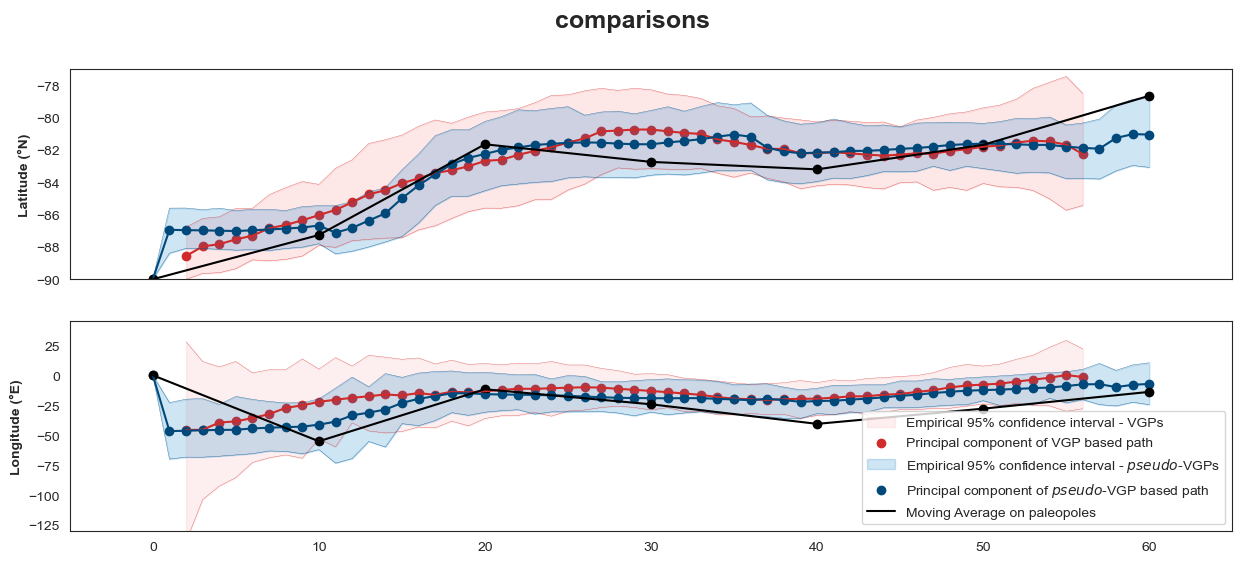

In [14]:
title = "comparisons"

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,6))
fig.suptitle(title, fontsize= 18, fontweight ='bold')
# axes[0].set_title('Latitude (°N)', fontsize=12, fontweight ='bold')
# axes[1].set_title('Longitude (°E)', fontsize=12, fontweight ='bold')
axes[0].set_ylabel(r'Latitude (°N)', fontweight ='bold')
axes[1].set_ylabel(r'Longitude (°E)', fontweight ='bold')

axes[0].set_ylim(-90,-77)
axes[1].set_ylim(-130,45)
axes[0].set_xlim(-5,65)
axes[1].set_xlim(-5,65)

# LATITUDE
# Gallo
axes[0].fill_between(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[2], ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[3], color= "#f98787", alpha=.20)
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[3],color="#d12a2a",linewidth=0.2)
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[2],color="#d12a2a",linewidth=0.2)
axes[0].scatter(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[1],color="#d12a2a")
axes[0].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[1],color="#d12a2a")
# Vaes
axes[0].fill_between(ensemble_PC_Vaes.X,ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[2],ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[3], color= "#0E7DC9", alpha=.20)
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[3],color="#00497A",linewidth=0.2)
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[2],color="#00497A",linewidth=0.2)
axes[0].scatter(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[1],color="#00497A")
axes[0].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[1],color="#00497A")
#CLASSIC
axes[0].plot(RM_1_classic.age, RM_1_classic.plat, '-',color="black") #CLASSIC
axes[0].scatter(RM_1_classic.age, RM_1_classic.plat, color="black") #CLASSIC

# LONGITUDE
# Gallo
axes[1].fill_between(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[0], ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[1], color= "#f9afaf", alpha=.20,label=f"Empirical {quantile}% confidence interval - VGPs")
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[1],color="#d12a2a",linewidth=0.2)
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.Lat_Lon_bounds(quantile)[0],color="#d12a2a",linewidth=0.2)
axes[1].plot(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[0], '-',color="#d12a2a")
axes[1].scatter(ensemble_PC_Gallo.X, ensemble_PC_Gallo.PC(quantile)[0],color="#d12a2a",label="Principal component of VGP based path")
# Vaes
axes[1].fill_between(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[0], ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[1], color= "#0E7DC9", alpha=.20,label=f"Empirical {quantile}% confidence interval - $pseudo$-VGPs")
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[1],color="#00497A",linewidth=0.2)
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.Lat_Lon_bounds(quantile)[0],color="#00497A",linewidth=0.2)
axes[1].plot(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[0], '-',color="#00497A")
axes[1].scatter(ensemble_PC_Vaes.X, ensemble_PC_Vaes.PC(quantile)[0],color="#00497A",label="Principal component of $pseudo$-VGP based path")
# Classic
axes[1].plot(RM_1_classic.age, RM_1_classic.plon, '-',color="black", label = "Moving Average on paleopoles") #CLASSIC
axes[1].scatter(RM_1_classic.age, RM_1_classic.plon, color="black") #CLASSIC

plt.legend(loc="lower right")
# plt.savefig(os.path.join(current_path, '..')  + '/figures/4/lat_lon_comparison.svg', dpi =600, bbox_inches='tight')

# Misfit of the Classical approach vs. the psuedoVGP and our current approach

Here, we compare the results of the classic approach (running means on paleopoles) with the approach proposed in the current contribution and the Moving averages on $pseudo$-VGPs drawn from the Paleopoles _pdf_ s

In [15]:
for i, row in RM_1_classic.iterrows():
    
    mean_cartesian = spherical2cartesian([np.radians(row.plat),np.radians(row.plon)])
    
    ind = np.where(ensemble_PC_Gallo.X == row.age)    
    vgps_cart = spherical2cartesian([np.radians(ensemble_PC_Gallo.PC(quantile)[1][ind]), np.radians(ensemble_PC_Gallo.PC(quantile)[0][ind])])
    pseudo_cart = spherical2cartesian([np.radians(ensemble_PC_Vaes.PC(quantile)[1][ind]), np.radians(ensemble_PC_Vaes.PC(quantile)[0][ind])])  
    
    RM_1_classic.loc[i, 'Distance_to_pseudo']=np.degrees(GCD_cartesian(mean_cartesian,pseudo_cart))
    RM_1_classic.loc[i, 'Distance_to_VPGs']=np.degrees(GCD_cartesian(mean_cartesian,vgps_cart))
RM_1_classic_melt = RM_1_classic[['age','Distance_to_pseudo','Distance_to_VPGs']].melt('age', var_name='method', value_name='Angle')

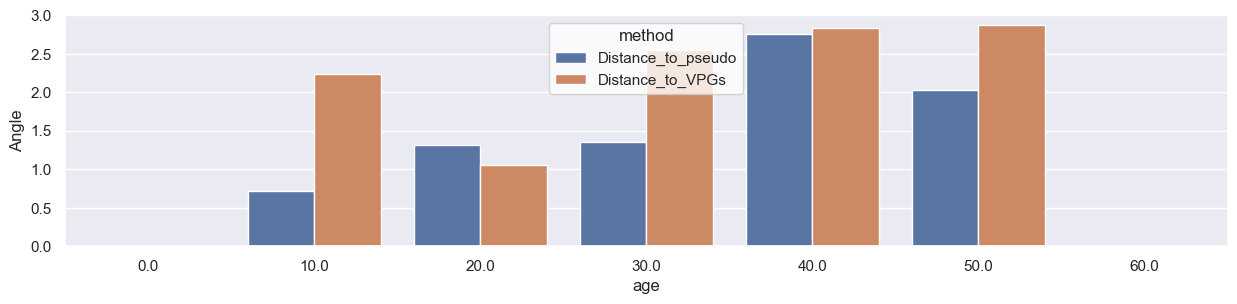

In [16]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,3))
ax.set_xlim(0,65)
ax.set_ylim(0,3)
sns.set_style("white")
sns.barplot(x="age", y="Angle", hue = 'method', data=RM_1_classic_melt,ax=ax)
# ax.plot(ensemble_PC_Gallo.X, dist_VGP_pseudo, '-',color="black", label = "Distance between pseudo-VGPs and VGPs")

plt.savefig(os.path.join(current_path, '..')  + '/figures/4/4c_gcds.svg', dpi =600, bbox_inches='tight')

### Calculate the distance between the Moving Average on pseudo-VGPs (Vaes et al., 2022) and the VGPs (this Study)

In [17]:
dist_VGP_pseudo = []
for i in ensemble_PC_Gallo.X:
    ind_vgps = np.where(ensemble_PC_Gallo.X == int(i))[0][0]
    ind_pse = np.where(ensemble_PC_Vaes.X == int(i))[0][0]
    vgps_cart = spherical2cartesian([np.radians(ensemble_PC_Gallo.PC(quantile)[1][ind_vgps]), np.radians(ensemble_PC_Gallo.PC(quantile)[0][ind_vgps])])
    pseudo_cart = spherical2cartesian([np.radians(ensemble_PC_Vaes.PC(quantile)[1][ind_pse]), np.radians(ensemble_PC_Vaes.PC(quantile)[0][ind_pse])])  
    dist_VGP_pseudo.append(np.degrees(GCD_cartesian(vgps_cart,pseudo_cart)))

dist_VGP_pseudo = np.array(dist_VGP_pseudo)
df_dist_pseudo_2_vgp = pd.DataFrame({'age': ensemble_PC_Gallo.X,
                                     'Angle':dist_VGP_pseudo})
                    
df_dist_pseudo_2_vgp['method']='pseudo_2_vgps'

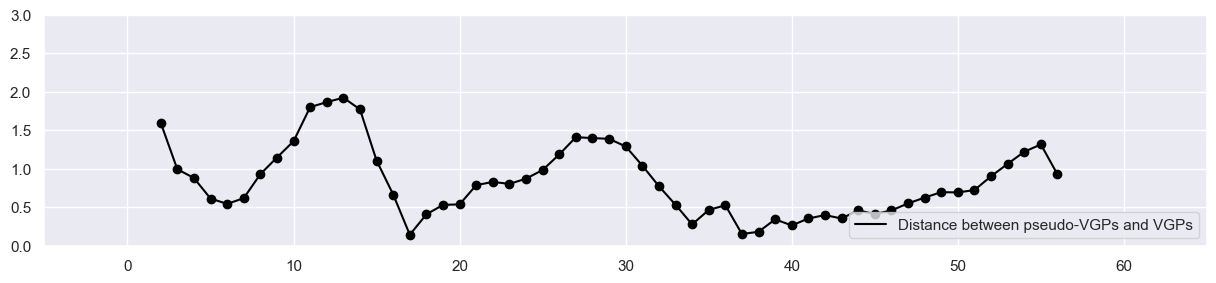

In [18]:
sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(15,3))
ax.set_xlim(-5,65)
ax.set_ylim(0,3)

# sns.pointplot(x='age', y='Angle', color='#333', data=df_dist_pseudo_2_vgp,ax=ax) # on secondary ax2
ax.plot(ensemble_PC_Gallo.X, dist_VGP_pseudo, '-',color="black", label = "Distance between pseudo-VGPs and VGPs")
ax.scatter(ensemble_PC_Gallo.X, dist_VGP_pseudo, color = 'black')
plt.legend(loc="lower right")
plt.savefig(os.path.join(current_path, '..')  + '/figures/4/4c_gcds_pseudo_vgps.svg', dpi =600, bbox_inches='tight')

## APWP from this study (Figure 4a)

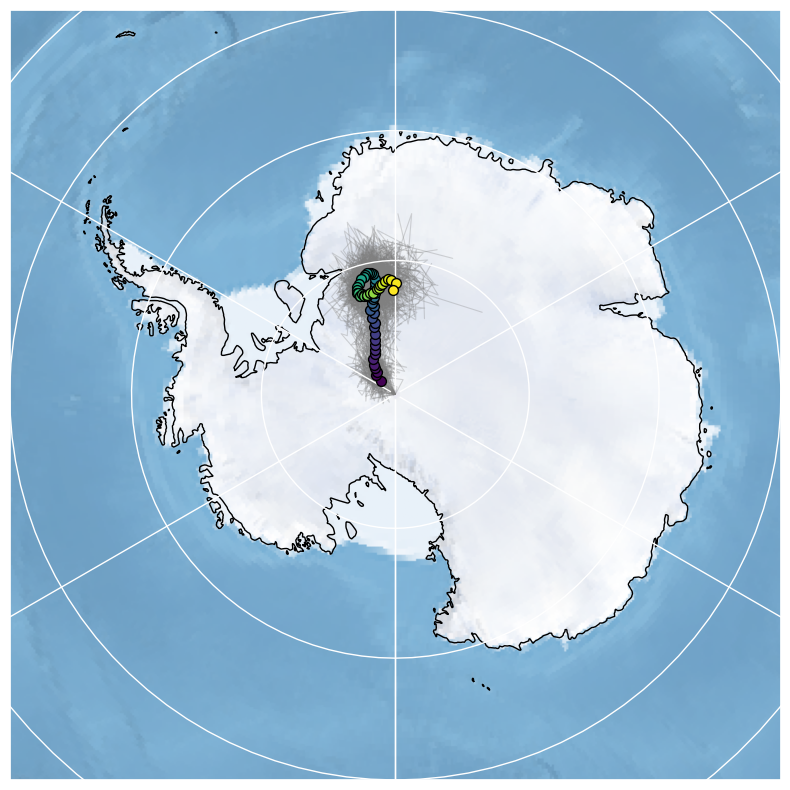

In [19]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_Gallo.PC(quantile)[0].tolist(), ensemble_PC_Gallo.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)
    
for i in zip(ensemble_PC_Gallo.PC(quantile)[1].tolist(), ensemble_PC_Gallo.PC(quantile)[0].tolist(),ensemble_PC_Gallo.X.tolist(), df_RM_ensemble['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],ensemble_PC_Gallo.X.min(),ensemble_PC_Gallo.X.max(),ax)
    
# Runs in grey (just plotting 50 runs)
for run, df_run in df_RM_ensemble[df_RM_ensemble['run']<50].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)
# plt.savefig(os.path.join(current_path, '..')  + '/figures/4/MovAverga_thisStudy.svg', dpi =600, bbox_inches='tight')  
plt.show()

## Vaes et al. (2022) Approach - Running mean on $pseudo$-VGPs

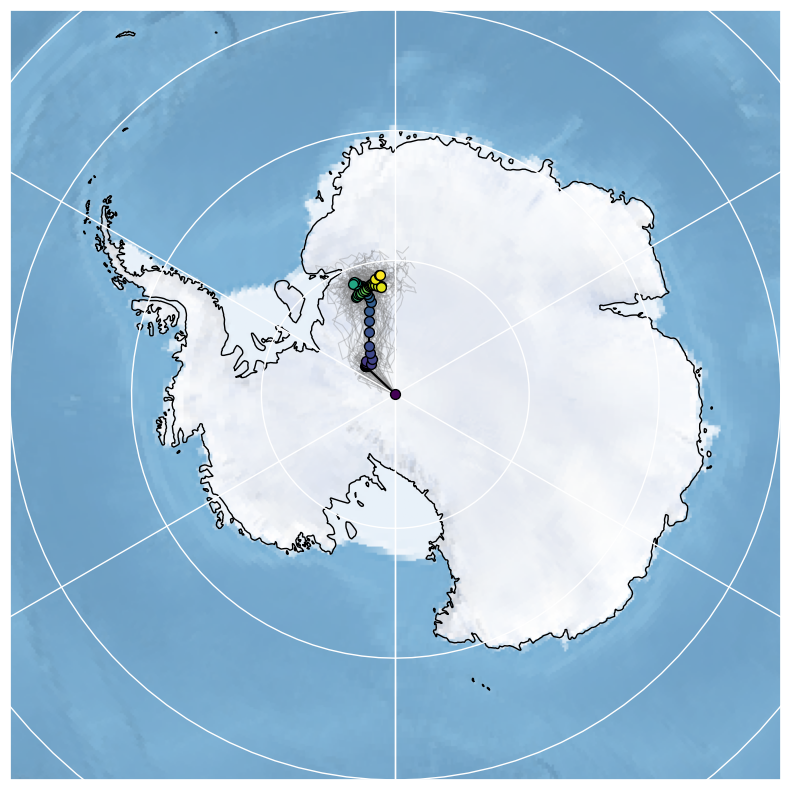

In [22]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path for the time-varying Principal Component.
plt.plot(ensemble_PC_Vaes.PC(quantile)[0].tolist(), ensemble_PC_Vaes.PC(quantile)[1].tolist(),transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)
   
for i in zip(ensemble_PC_Vaes.PC(quantile)[1].tolist(), ensemble_PC_Vaes.PC(quantile)[0].tolist(),ensemble_PC_Vaes.X.tolist(), RM_2_ensemble_pseudoVGP['age'].unique().transpose()):
    plot_pole(i[0],i[1],i[2],0,60,ax)
    
# Runs in grey (just plotting 50 runs)
for run, df_run in RM_2_ensemble_pseudoVGP[RM_2_ensemble_pseudoVGP['run']<50].groupby('run'):
    plt.plot(df_run.plon.tolist(), df_run.plat.tolist(),transform = ccrs.Geodetic(), color = "grey", alpha = 0.3, linewidth=0.8, zorder=0)
plt.savefig(os.path.join(current_path, '..')  + '/figures/4/MovAverages_VaesApproach.svg', dpi =600, bbox_inches='tight')  
plt.show()

## Classic Moving Averages (Time-step = 10 Ma, Window width = 20 Ma)

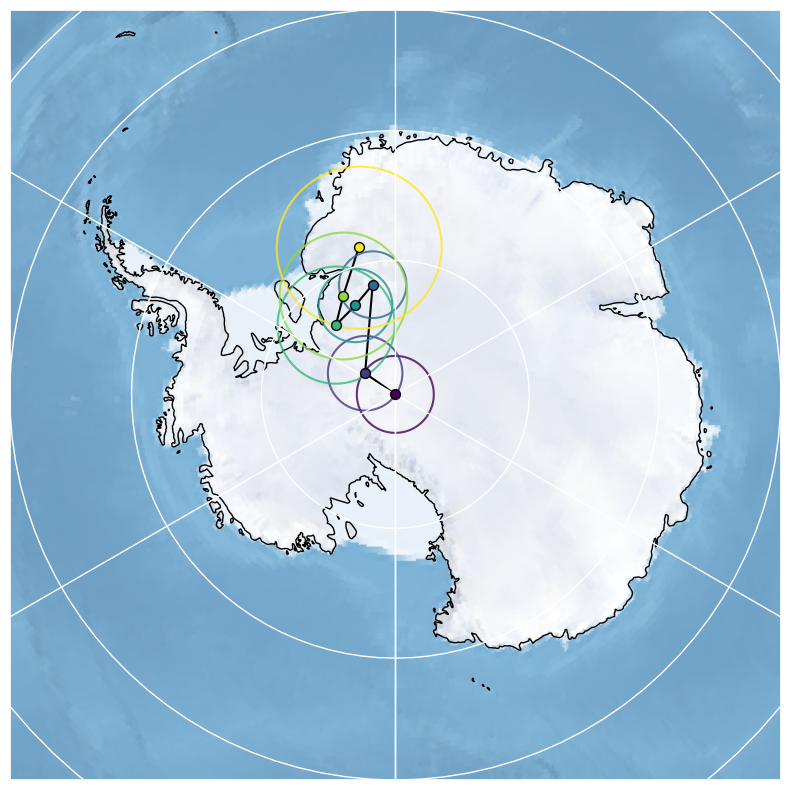

In [23]:
# Visualization
extent = [-180,180,-60,-60]
fig = plt.figure(figsize=(20,10))
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0)
ax = plt.axes(projection=proj)
ax.coastlines(), ax.stock_img(), ax.gridlines()
ax.set_extent(extent, crs = ccrs.PlateCarree())

# A black path to connect the poles.
plt.plot(RM_1_classic['plon'],RM_1_classic['plat'],transform = ccrs.Geodetic(), color = "black", alpha = 1, linewidth=1.5, zorder=1)

#Color coded Paleopoles and 95 circles.
for i in zip(RM_1_classic['plat'].tolist(),RM_1_classic['plon'].tolist(), RM_1_classic['A95'].tolist(), RM_1_classic['age'].unique().transpose()):
    plot_pole_A95(i[0],i[1],i[2],i[3],0,60,ax)
plt.savefig(os.path.join(current_path, '..')  + '/figures/4/MovAverage_CLASSIC.svg', dpi =600, bbox_inches='tight')    
plt.show()